In [13]:
import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import copy
import torch
from torchvision import transforms as T
from torch.optim import lr_scheduler
import os
import math
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from skimage import io
import umap
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import splitfolders
print(device)

cpu


# Data preparation

In [3]:
# Data set class
class FaceDataset(Dataset):

    def __init__(self, image_dir, transform=None):
        
        """Function to load images into Tensor
            Args: 
                - image_dir : directory of images
                - Return : a dictonary with images and labels
        """
        self.image_dir = image_dir
        self.image_dict = self.load_image()
        self.transform = transform


    def __len__(self) :
        return len(self.image_dict["label"])


    def __getitem__(self, index) :
        
        
        path = torch.from_numpy(io.imread(self.image_dict["img_dir"][index],
                                         as_gray=True).astype(np.float32)).unsqueeze(0)
        label_bin = self.image_dict["label_bin"][index]
        label_to_token = self.image_dict["label"][index]

        if self.transform:
            img = path * 255.0
            img = torch.clip(img, 0.0, 255.0)
            img = img.type(torch.uint8)
            path = self.transform(img)
            path = path.type(torch.float32)/path.max()
        
        return path, label_bin, label_to_token


    def load_image(self) :
        img_dict = {"img_dir" : [], "label" : [], 'label_bin':[]}
        label_to_int = {"real":0,"easy":1,"mid_":2,"hard":3}
        for root, dirs, files in os.walk(self.image_dir):
            for img in files:
                img_dict["img_dir"].append(os.path.join(root, img))
                
                img_dict["label"].append(label_to_int[img[:4]])
                if img[:4] != 'real':
                    img_dict["label_bin"].append(1.0)
                else:
                    img_dict["label_bin"].append(0.0)
        img_dict["label_bin"] = torch.tensor(img_dict["label_bin"],dtype=torch.float32)
        img_dict["label"] = torch.tensor(img_dict["label"],dtype=torch.float32)
        return img_dict

In [4]:
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

def plot_embeddings(X, y, title):
    
    y = y.astype(int)
    X = QuantileTransformer().fit_transform(X)
    
    plt.figure(figsize = (10,10))
    for i in range(X.shape[0]):        
        plt.text(X[i, 0],
                 X[i, 1],
                 str(y[i]),
                 color=plt.cm.Dark2(y[i]),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE - ' + title, fontsize=16)
    plt.show()
    
    return

In [5]:
def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history[c])
        plt.legend(curves, loc='upper right')
        plt.show()

In [10]:
#splitfolders.ratio("./data", output="outputs",
    #seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 2041 files [04:25,  7.68 files/s]


In [11]:
data = FaceDataset("./outputs/train")
valid_data = FaceDataset("./outputs/val")
test_data = FaceDataset("./outputs/test")

In [12]:
# Load with Dataset class
policies = [T.AutoAugmentPolicy.CIFAR10, T.AutoAugmentPolicy.IMAGENET]
augmenters = [T.AutoAugment(policy) for policy in policies]

In [14]:
imagnet_data = FaceDataset("./outputs/train",transform=augmenters[1])
cifar_data = FaceDataset("./outputs/train",transform=augmenters[0])

train_data = ConcatDataset([data, 
                               #cifar_data, 
                               imagnet_data
                              ])
len(train_data)

3264

In [15]:
train_data_loader = DataLoader(dataset= train_data,batch_size=10, shuffle=True, 
                               drop_last=True)
valid_data_loader = DataLoader(dataset= valid_data,batch_size=10, shuffle=True, 
                               drop_last=True)
test_data_loader = DataLoader(dataset=test_data, batch_size=10, shuffle=True, 
                              drop_last=True)

In [8]:
tf = T.Compose([#transforms.Resize((30,30)),
    #transforms.Grayscale(num_output_channels=1),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    #transforms.ToTensor()
    ])

In [16]:
next(iter(train_data_loader))[0].shape

torch.Size([10, 1, 600, 600])

In [17]:
class MLPClassif(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassif, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.hidden3 = nn.Linear(hidden_size, hidden_size)
        #self.hidden4 = nn.Linear(hidden_size, hidden_size)
        self.out_layer = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(hidden_size, affine=False)

    
    def forward(self, x):

        #sigmoid = nn.Sigmoid()
        dropout = nn.Dropout(p=0.1)
        x = self.hidden1(x)
        x = self.relu(x)
        x = dropout(x)
        x = self.batchnorm(x)
        x = self.hidden2(x)
        x = self.relu(x)
        #x = dropout(x)
        x = self.batchnorm(x)
        x = self.hidden3(x)
        x = self.relu(x)
        #x = dropout(x)
        #x = self.hidden4(x)
        #x = self.relu(x)
        x = self.batchnorm(x)
        #x = dropout(x)
        out = self.out_layer(x)
        return out

In [18]:
model = MLPClassif(30*30, 100, 1)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
        

#torch.manual_seed(0)
model.apply(init_weights)

MLPClassif(
  (hidden1): Linear(in_features=900, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=100, bias=True)
  (out_layer): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (batchnorm): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [23]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc


def eval_binary_classifier(model, eval_dataloader, loss_fn):
    sigmoid = nn.Sigmoid()
    model.eval() 
    #model.to(device)
    transform = T.Resize(size = (30,30))
    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        loss, accuracy = 0, 0
        # Iterate over the dataset using the dataloader
        for (images, labels, _) in eval_dataloader:
            #images = torch.tensor(images, dtype=float)
            images = transform(images)
            
            #labels.to(device)
            images = images.reshape(images.shape[0], -1).to(device)
            #images.to(device)
            #print(images.shape)
            # Get the predicted labels
            y_predicted = model(images)

            l =loss_fn(y_predicted, labels.unsqueeze(1).to(device))
            loss += l.item()
            accuracy += accuracy_fn(labels.to(device), torch.round(sigmoid(y_predicted)).squeeze(1))
        accuracy = accuracy/len(eval_dataloader)

    return loss, accuracy

def train_val_binary_classifier(model, train_dataloader, valid_dataloader, num_epochs, 
                            loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    model_tr = model_tr.to(device)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    #optimizer = #torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    optimizer =torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    valid_loss, valid_acc = [], []
    acuracy = 0
    transform = T.Resize(size = (30,30))
    # Training loop

    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels, label_to_token) in enumerate(train_dataloader):
            images = transform(images)
            images = images.reshape(images.shape[0], -1)
            
            
            y_pred = model_tr(images.to(device))
            #print(f"size of ypred {y_pred}")
            # print(f"size of labels {labels.unsqueeze(1).shape}")
            l = loss_fn(y_pred, labels.unsqueeze(1).to(device))

            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            loss_current_epoch +=  l.item()
            #accuracy += accuracy_fn(labels, torch.round(sigmoid(y_pred)).squeeze(1))


        scheduler.step()
        loss_all_epochs.append(loss_current_epoch)
        val_loss, accuracy = eval_binary_classifier(model_tr, 
                                                 valid_dataloader,
                                                 loss_fn)
        valid_loss.append(val_loss)
        valid_acc.append(accuracy)

                                    
        if verbose:
            print(f"\nEpoch [{epoch+1}/{num_epochs}]"
                  f"\nTrain loss: {loss_current_epoch:.5f} | "
                  f"Test loss: {val_loss:.5f} | Test acc: {accuracy:.2f}%\n")
            

            
        
    return model_tr, {'loss': loss_all_epochs,'val_loss': valid_loss, 'val_accuracy': valid_acc}

In [24]:
def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm="gray", norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos'):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns: 
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm,)
#         img=axs.imshow(xx,   cmap = cm, interpolation=interpolation)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    fig.tight_layout(pad=0.8)
    plt.show()

- initial network with imagenet augmentation : acc 67%

In [30]:
#model = MLPClassif(30*30, 100, 1)
num_epochs = 20
learning_rate = 0.11
loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)
print(next(model.parameters()).is_cuda)
model_trained, history = train_val_binary_classifier(model, 
                                                                     train_data_loader,
                                                                     valid_data_loader,
                                                                     num_epochs,loss_fn, 
                                                                     learning_rate, 
                                                                     verbose=True)

False

Epoch [1/30]
Train loss: 261.96412 | Test loss: 22.87547 | Test acc: 53.00%


Epoch [2/30]
Train loss: 280.97999 | Test loss: 14.03900 | Test acc: 46.00%


Epoch [3/30]
Train loss: 243.82902 | Test loss: 14.74298 | Test acc: 52.00%


Epoch [4/30]
Train loss: 236.08145 | Test loss: 14.17436 | Test acc: 47.00%


Epoch [5/30]
Train loss: 232.36273 | Test loss: 13.99085 | Test acc: 55.50%


Epoch [6/30]
Train loss: 229.83447 | Test loss: 13.48148 | Test acc: 59.00%


Epoch [7/30]
Train loss: 228.36801 | Test loss: 13.82697 | Test acc: 54.00%


Epoch [8/30]
Train loss: 223.61199 | Test loss: 13.86663 | Test acc: 56.00%


Epoch [9/30]
Train loss: 222.58974 | Test loss: 13.65612 | Test acc: 59.00%


Epoch [10/30]
Train loss: 219.11230 | Test loss: 14.60138 | Test acc: 51.00%


Epoch [11/30]
Train loss: 216.13791 | Test loss: 13.88079 | Test acc: 60.50%


Epoch [12/30]
Train loss: 214.70158 | Test loss: 13.69961 | Test acc: 59.50%


Epoch [13/30]
Train loss: 213.45877 | Test loss: 13.65

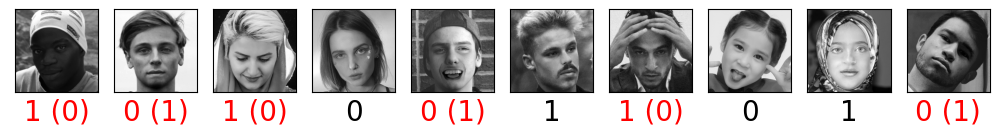

In [31]:
sigmoid = nn.Sigmoid()
x_test, y_test,_ = next(iter(test_data_loader))
transform_ = T.Resize(size = (30,30))
x_t = transform_(x_test)
y_pred = model(x_t.squeeze().view(10,-1))
y_test = y_test.numpy().astype(int)
y_pred = torch.round(sigmoid(y_pred)).squeeze(1).detach().numpy().astype(int)
x_test = x_test.squeeze().numpy()
plot_images(x_test, y_test, range(0,10), columns=12, x_size=1, y_size=1, y_pred=y_pred)

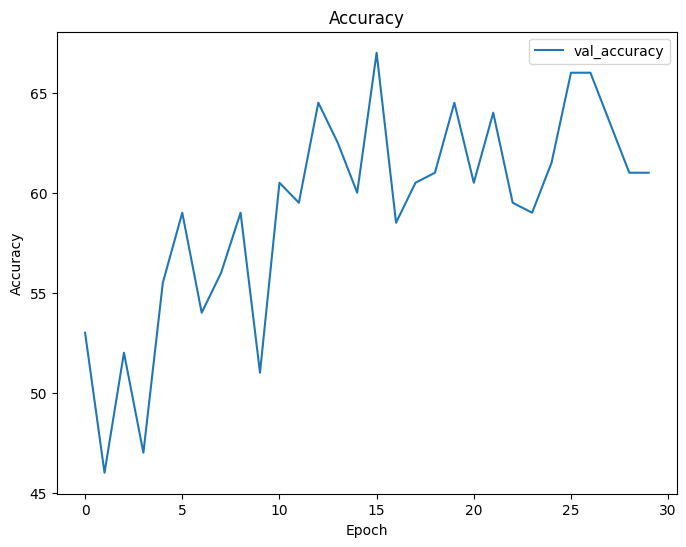

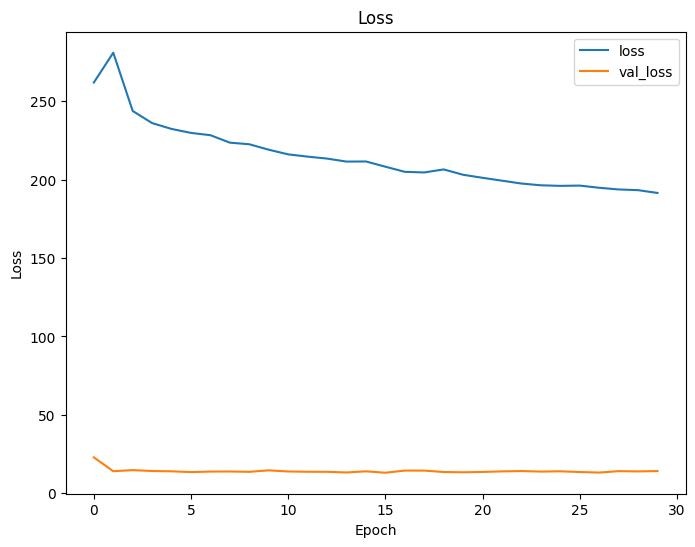

In [32]:
plot_history(history)

In [47]:
eval_binary_classifier(model, test_data_loader, loss_fn)

(14.345660626888275, 44.5)

In [87]:
def extract_mlp_layer(model, data_loader, len_dataset):
    images_tot = torch.empty((len_dataset, 100), dtype=torch.float)
    labels_im_tot = torch.empty(len_dataset, dtype=torch.float)
    transform = T.Resize(size = (30,30))
    model.to("cpu")
    model.eval()
    with torch.no_grad():
        for ib, (images, labels) in enumerate(data_loader):
            indices_b = torch.arange(ib*batch_size, (ib+1)*batch_size)
            #print(indices_b, labels.shape)
            labels_im_tot[indices_b] = labels.float()
            images = transform(images)
            images = images.reshape(images.shape[0], -1)
            out = model(images)
            in_im_vec = activation["hidden3"].reshape(batch_size, -1)
            images_tot[indices_b, :] = in_im_vec

    images_tot = images_tot.numpy()
    labels_im_tot = labels_im_tot.numpy()
    print('Size of vectorized input images:', images_tot.shape)
    print('Size of the tensor storing labels:', labels_im_tot.shape)
    return images_tot, labels_im_tot

In [ ]:
activation = {}
mlp_layer = model.hidden3.register_forward_hook(getActivation('hidden3'))

In [35]:
batch_size=32
X, y = extract_mlp_layer(model, train_data_loader, len(train_dataset))

Size of vectorized input images: (2939, 100)
Size of the tensor storing labels: (2939,)


In [42]:
X = TSNE(perplexity=45,n_components=2, init='pca', learning_rate='auto').fit_transform(X)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


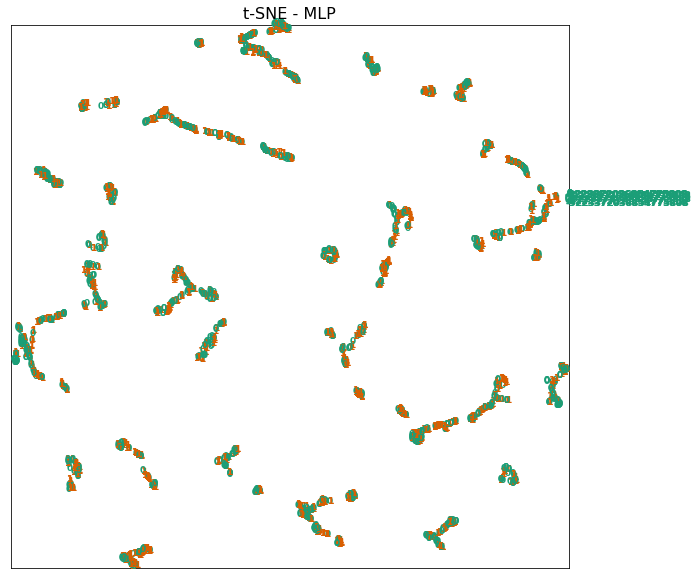

In [43]:
plot_embeddings(X, y, "MLP")

In [36]:
class CNN(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=1):
        super(CNN, self).__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels= num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           #nn.BatchNorm2d(num_channels1, affine=False),
                           nn.MaxPool2d(kernel_size=2))
        
        self.conv_block2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           #nn.BatchNorm2d(num_channels2,affine=False),
                           nn.MaxPool2d(kernel_size=2))
        self.fc = nn.Linear(32*7*7, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        out = self.fc(x.view(-1, 32*7*7))
        return out

In [38]:
cnn_model = CNN()
cnn_model = cnn_model.to(device)
print(next(cnn_model.parameters()).is_cuda)

False


In [41]:
def training_cnn_classifier(model, train_dataloader, valid_dataloader, num_epochs,
                            loss_fn, learning_rate, verbose=True):

    model_tr = copy.deepcopy(model)
    model_tr = model_tr.to(device)
    
    model_tr.train()
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    valid_acc, valid_loss = [], []
    transform = T.Resize(size = (30,30))
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels, _) in enumerate(train_dataloader):
            images = transform(images).to(device)
            labels = labels.to(device)
            y_pred = model_tr(images)
            l = loss_fn(y_pred, labels.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            loss_current_epoch += l.item()
            optimizer.step() #update parameters

        
        scheduler.step() # Update the learning rate
        loss_all_epochs.append(loss_current_epoch)
        val_loss, accuracy = eval_cnn_classifier(model_tr, 
                                                 valid_dataloader,
                                                 loss_fn)
        valid_loss.append(val_loss)
        valid_acc.append(accuracy)
        if verbose:
            # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
            print(f"\nEpoch [{epoch+1}/{num_epochs}]"
                  f"\nTrain loss: {loss_current_epoch:.5f} | "
                  f"Test loss: {val_loss:.5f} | Test acc: {accuracy:.2f}%\n")
        
    return model_tr, {'loss': loss_all_epochs,'val_loss': valid_loss, 'val_accuracy': valid_acc}

def eval_cnn_classifier(model, eval_dataloader,loss_fn):
    sigmoid = nn.Sigmoid()
    # Set the model in evaluation mode
    model.eval() 
    transform = T.Resize(size = (30,30))
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct,loss = 0, 0
        total = 0
        for images, labels,_ in eval_dataloader:
            images = transform(images).to(device)
            labels = labels.to(device)
            y_predicted = model(images)
            label_predicted = torch.round(sigmoid(y_predicted)).squeeze(1) #y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
            l =loss_fn(y_predicted, labels.unsqueeze(1).to(device))
            loss += l.item()
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return loss, accuracy

In [42]:
model_cnn = CNN()
model_cnn.to(device)
num_epochs = 20
learning_rate = 0.3
loss_fn = nn.BCEWithLogitsLoss()
model_cnn, history= training_cnn_classifier(model_cnn, train_data_loader,valid_data_loader, num_epochs,
                            loss_fn, learning_rate, verbose=True)


Epoch [1/20]
Train loss: 227.11983 | Test loss: 13.82026 | Test acc: 55.50%


Epoch [2/20]
Train loss: 224.37091 | Test loss: 13.56851 | Test acc: 59.00%


Epoch [3/20]
Train loss: 222.60120 | Test loss: 13.44755 | Test acc: 56.00%


Epoch [4/20]
Train loss: 221.48594 | Test loss: 13.76298 | Test acc: 57.00%


Epoch [5/20]
Train loss: 221.22673 | Test loss: 13.26919 | Test acc: 61.00%


Epoch [6/20]
Train loss: 218.42929 | Test loss: 13.22518 | Test acc: 61.50%


Epoch [7/20]
Train loss: 220.43492 | Test loss: 13.27275 | Test acc: 59.00%


Epoch [8/20]
Train loss: 215.01576 | Test loss: 13.36582 | Test acc: 59.00%


Epoch [9/20]
Train loss: 212.06952 | Test loss: 13.33341 | Test acc: 59.00%


Epoch [10/20]
Train loss: 210.18375 | Test loss: 13.57156 | Test acc: 58.50%


Epoch [11/20]
Train loss: 203.91528 | Test loss: 13.74181 | Test acc: 58.00%


Epoch [12/20]
Train loss: 201.88617 | Test loss: 13.64954 | Test acc: 60.00%


Epoch [13/20]
Train loss: 195.08281 | Test loss: 13.96048 | 

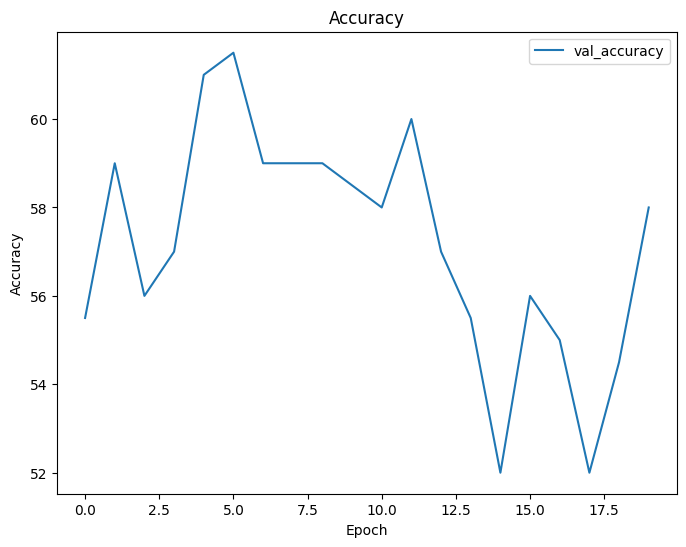

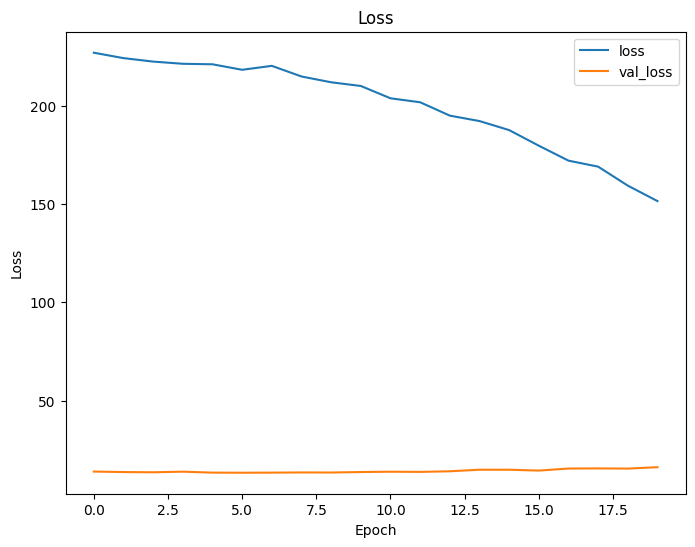

In [43]:
plot_history(history)

In [ ]:
model_cnn = CNN()
model_cnn.to(device)
num_epochs = 50
learning_rate = 0.25
loss_fn = nn.BCEWithLogitsLoss()
transform_ = transforms.Resize(size = (30,30))
model_cnn.train()
    
    # Define the optimizer
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # Initialize a list to record the training loss over epochs
loss_all_epochs = []
    
    # Training loop
for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
    loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
    for batch_index, (images, labels) in enumerate(train_data_loader):
        images = transform_(images).to(device)
        print(images.shape)
        labels = labels.to(device)
        y_pred = model_cnn(images)
        l = loss_fn(y_pred, labels.view(-1, 1))
        optimizer.zero_grad()
        l.backward()
        loss_current_epoch += l.item()
        optimizer.step() #update parameters

        # At the end of each epoch, record and display the loss over all batches
    scheduler.step()
    loss_all_epochs.append(loss_current_epoch)
    
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))

In [45]:
eval_cnn_classifier(model_cnn, test_data_loader, loss_fn)

(15.164041548967361, 57.5)

In [88]:
activation = {}
cnn_layer = model_cnn.conv_block2.register_forward_hook(getActivation('conv_block2'))

In [89]:
batch_size = 10
len_dataset=len(train_data)
transform = T.Resize(size = (30,30))
images_tot = torch.empty((len_dataset, 32*49), dtype=torch.float)
labels_im_tot = torch.empty(len_dataset, dtype=torch.float)
model_cnn.to('cpu')
model_cnn.eval()
with torch.no_grad():
    for ib, (images, labels) in enumerate(train_data_loader):
        images = transform(images)
        indices_b = torch.arange(ib*batch_size, (ib+1)*batch_size)
        labels_im_tot[indices_b] = labels.float()
        out = model_cnn(images)
        in_im_vec = activation["conv_block2"].reshape(batch_size, -1)
        images_tot[indices_b, :] = in_im_vec

images_tot = images_tot.numpy()
labels_im_tot = labels_im_tot.numpy()
print('Size of vectorized input images:', images_tot.shape)
print('Size of the tensor storing labels:', labels_im_tot.shape)

Size of vectorized input images: (2939, 1568)
Size of the tensor storing labels: (2939,)


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (500). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)


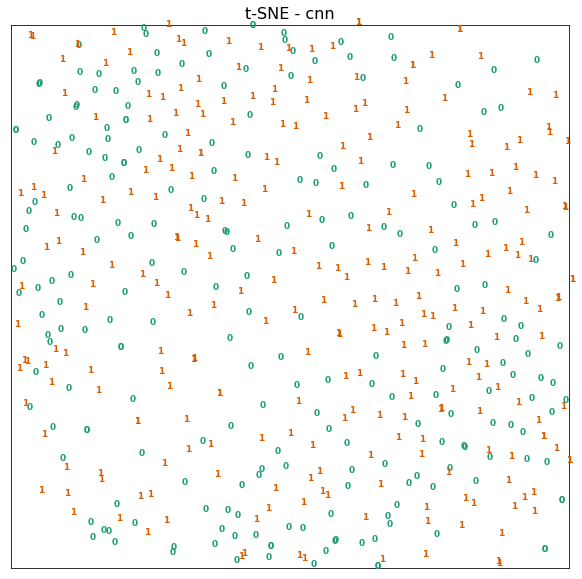

In [95]:
X = TSNE(n_components=2, init='pca', learning_rate='auto',n_iter=2000).fit_transform(images_tot[:500,:])
plot_embeddings(X, labels_im_tot[:500], "cnn")

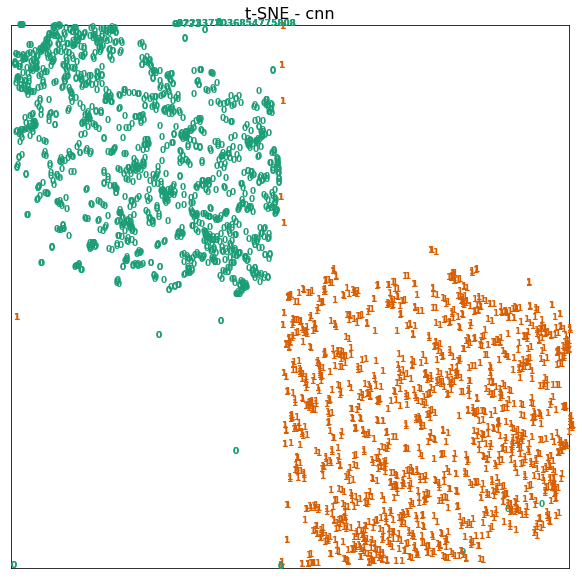

In [129]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(images_tot[:,:],
                                                              y=labels_im_tot[:].astype(int)
                                                             )
plot_embeddings(standard_embedding, labels_im_tot[:], "cnn")

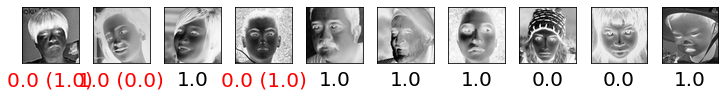

In [173]:
sigmoid = nn.Sigmoid()
x_test, y_test = next(iter(test_data_loader))
transform_ = transforms.Resize(size = (30,30))
x_t = transform_(x_test)
y_pred = model_cnn(x_t)
y_test = y_test.numpy()
y_pred = torch.round(sigmoid(y_pred)).squeeze(1).detach().numpy()
x_test = x_test.squeeze().numpy()
plot_images(x_test, y_test, range(0,10), columns=12, x_size=1, y_size=1, y_pred=y_pred)

In [157]:
def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    cm = confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [174]:
transform_ = transforms.Resize(size = (30,30))
true_labels, pred_labels = [], []
for x, y in test_data_loader:
    x_t = transform_(x)
    y_pred = model_cnn(x_t)
    true_labels += y.tolist()
    prediction = torch.round(sigmoid(y_pred)).squeeze(1).detach().numpy().tolist()
    pred_labels += prediction

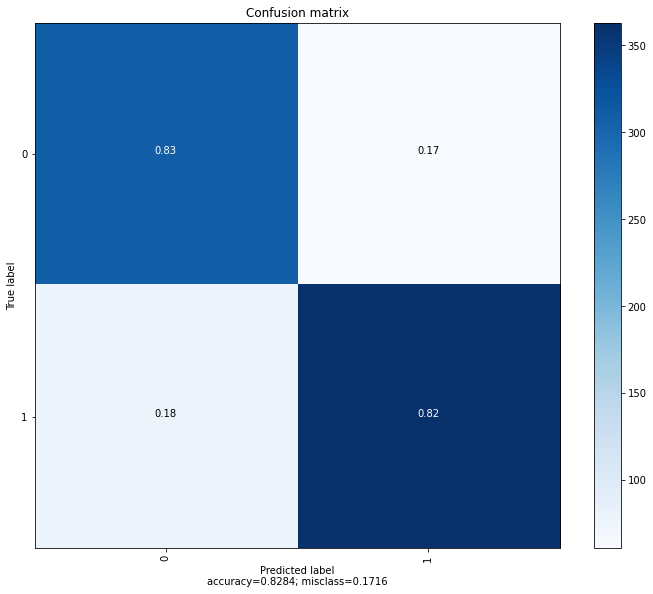

In [175]:
plot_confusion_matrix(y_true=np.array(true_labels),y_pred=np.array(pred_labels),
                          target_names=[0, 1])